In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\fizza\appdata\local\temp\pip-req-build-l3eruot0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36834 sha256=546f14e73681e171eba748246634d958d8ca7f23189a539070405de78e22cb56
  Stored in directory: C:\Users\fizza\AppData\Local\Temp\pip-ephem-wheel-cache-opa6rx7r\wheels\10\cf\59\9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\fizza\AppData\Local\Temp\pip-req-build-l3eruot0'


In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [82]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

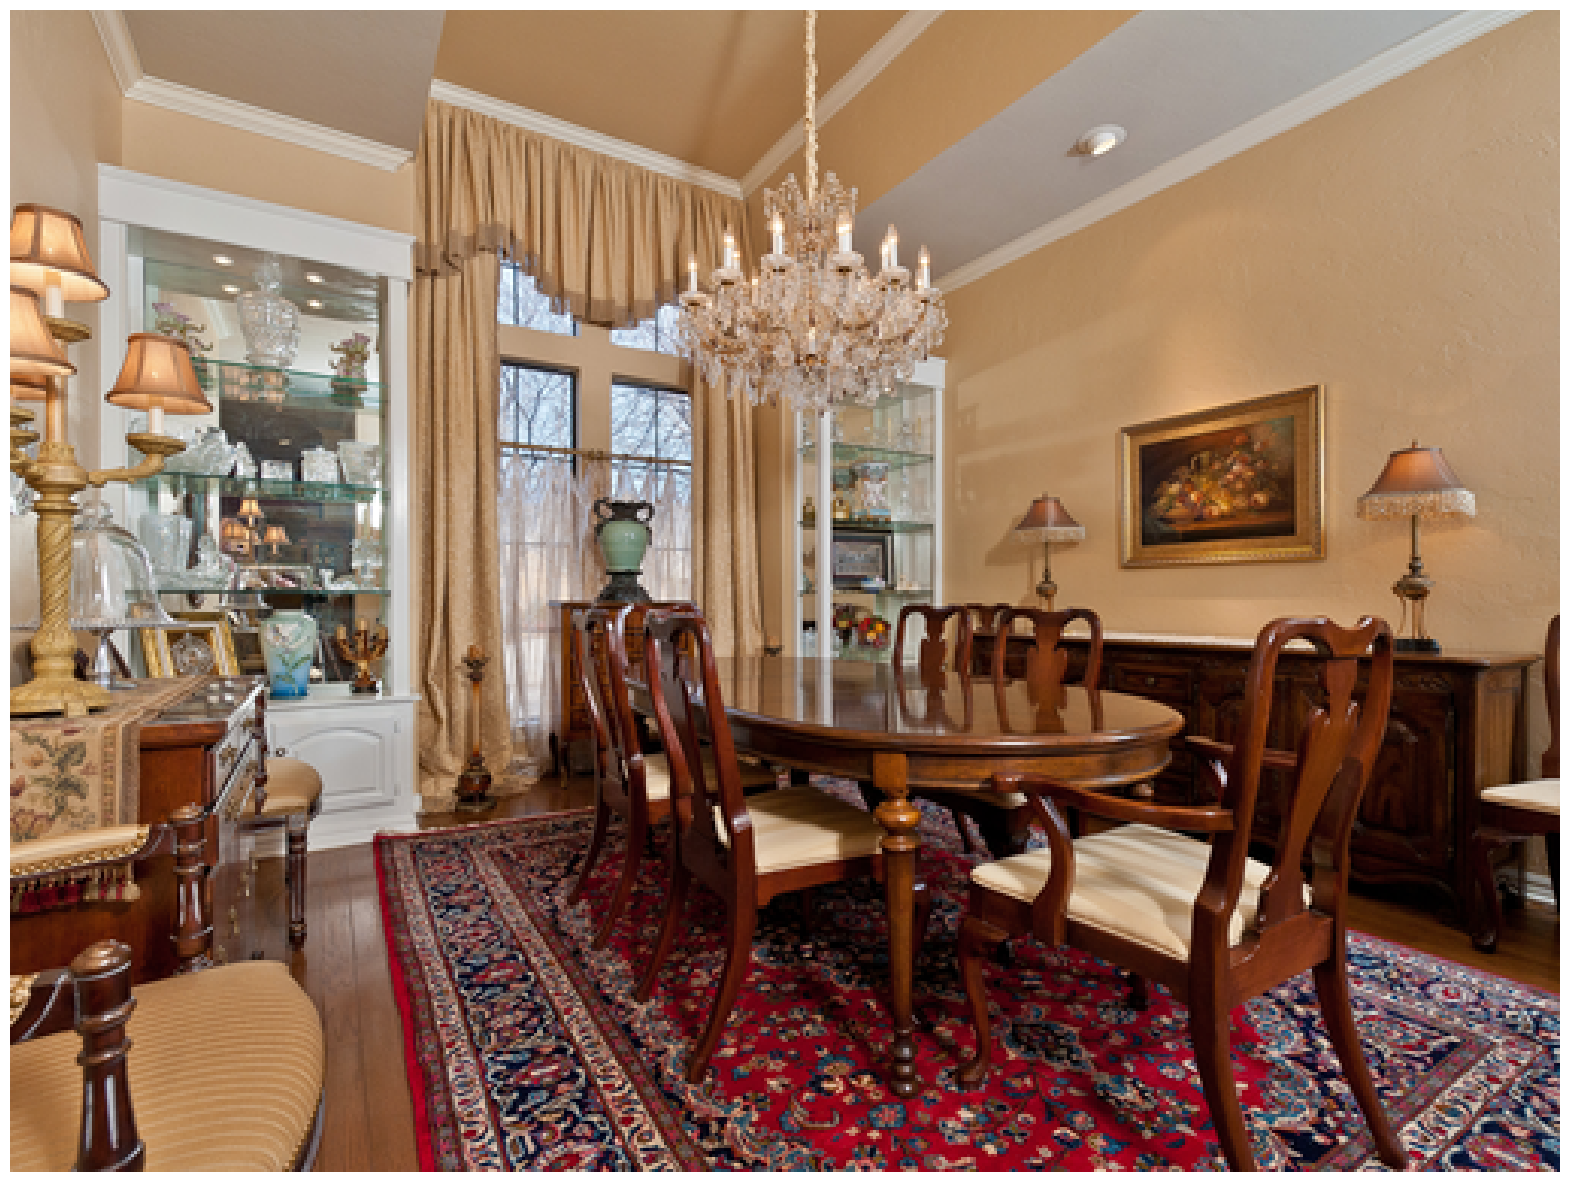

In [83]:
image = cv2.imread('90785.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [84]:
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_l_0b3195.pth"
model_type = "vit_l"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

c:\Users\fizza\anaconda3\envs\iid\lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [76]:
masks = mask_generator.generate(image)

In [7]:
print(len(masks))
print(masks[0].keys())

135
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


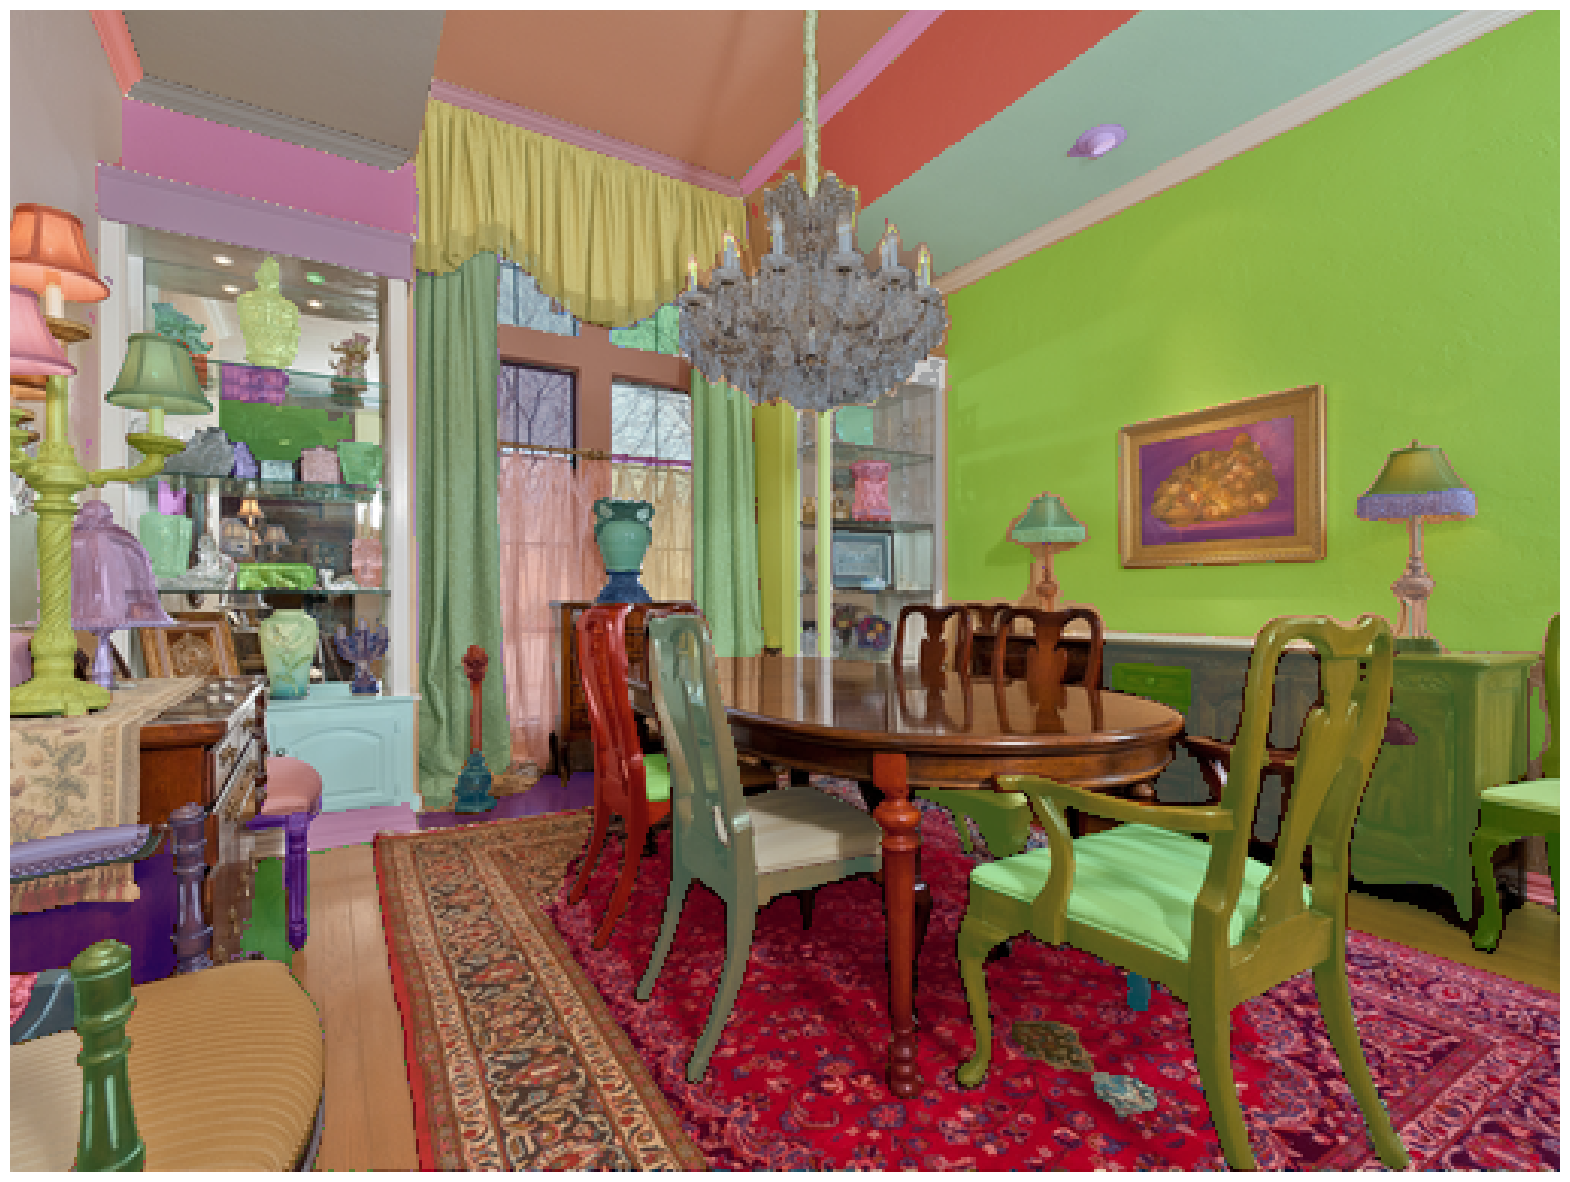

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [89]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [90]:
masks2 = mask_generator_2.generate(image)
len(masks2)

356

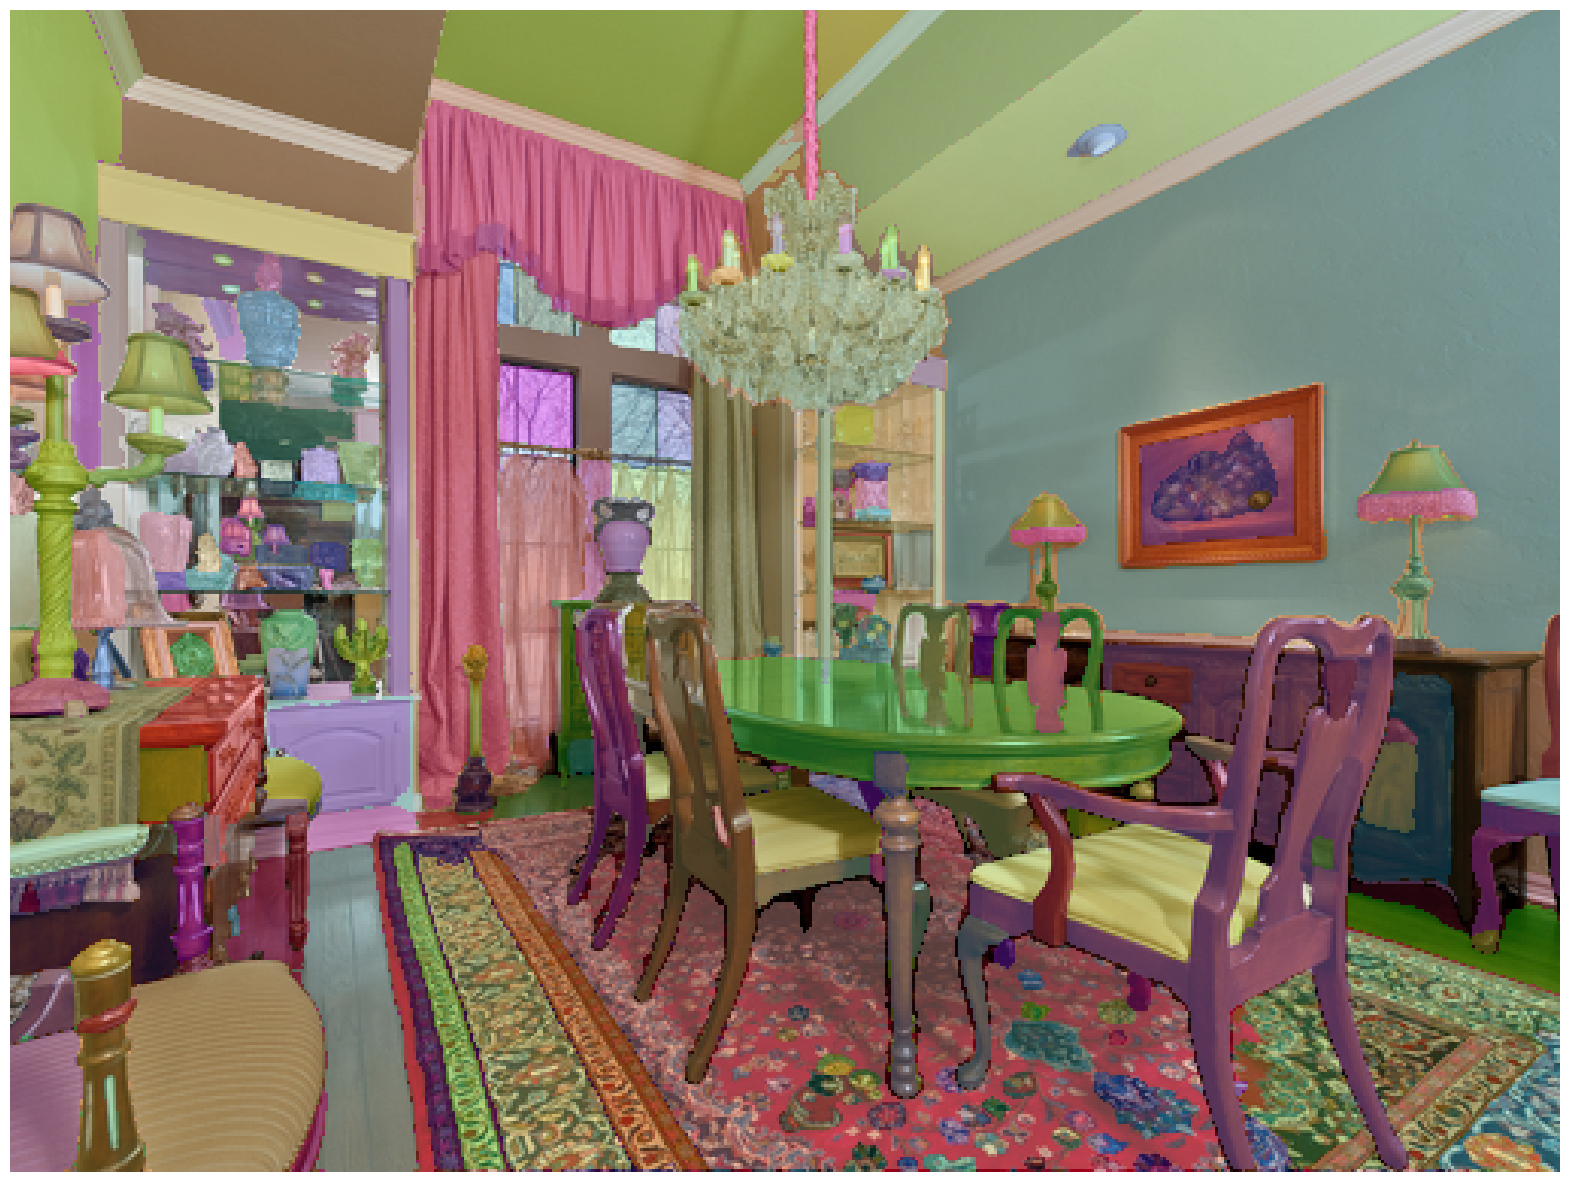

In [91]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [20]:
image.shape

(384, 512, 3)

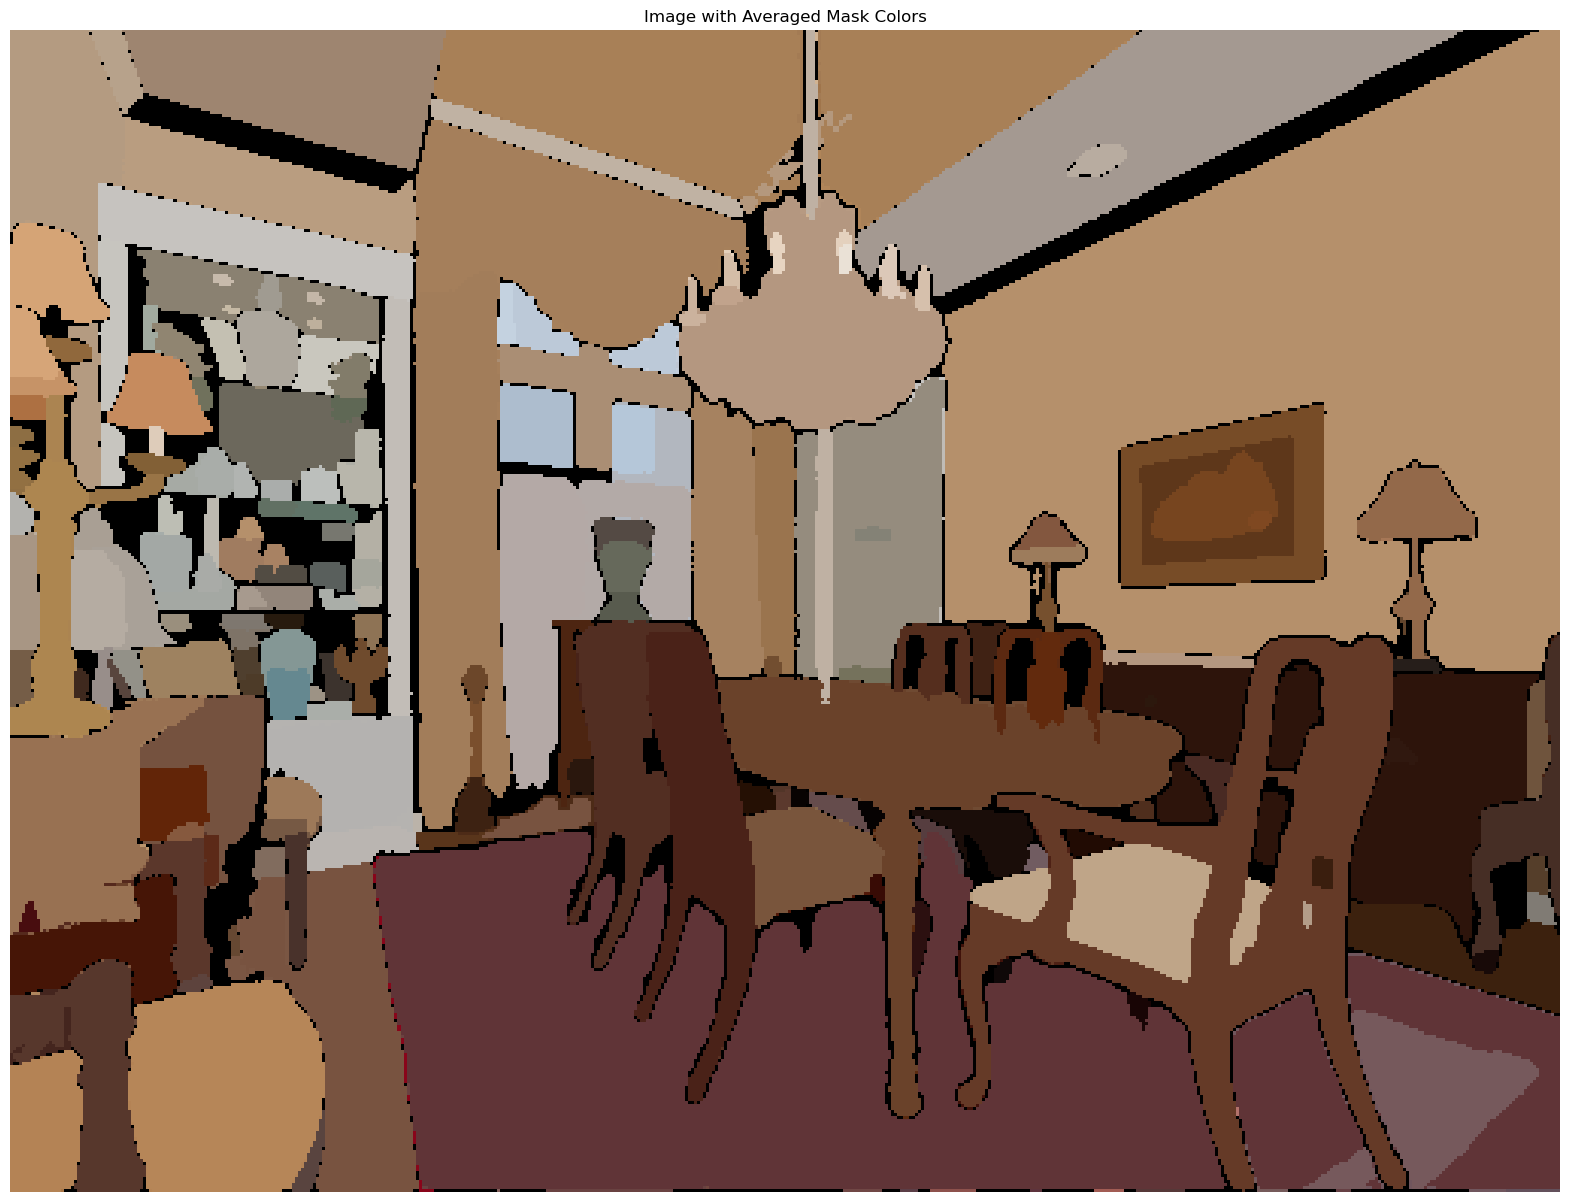

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def create_average_color_mask(image, masks):
    result = np.zeros_like(image, dtype=np.float32)

    for mask in masks:
        segmentation = mask['segmentation']
        average_color = image[segmentation].mean(axis=0)
        result[segmentation] = average_color
    result = (result).astype(np.uint8)  # Assuming input image is in 0-1 range
    return result

# Create the averaged mask-colored image
average_mask_image = create_average_color_mask(image, masks2)
plt.figure(figsize=(20, 20))
plt.imshow(average_mask_image)
plt.axis('off')
plt.title("Image with Averaged Mask Colors")
plt.show()


In [26]:
image.shape

(384, 512, 3)

(384, 512, 3)
cropped image (384, 512, 3)
cropped mask (384, 512)
mask_pixels (26733, 3)
average_color [180.92686941 144.67414806 107.47345977]
cropped image (384, 512, 3)
cropped mask (384, 512)
mask_pixels (4384, 3)
average_color [110.87317518  73.31911496  48.72125912]
cropped image (384, 512, 3)
cropped mask (384, 512)
mask_pixels (28251, 3)
average_color [95.86956214 52.4415065  55.90694135]
cropped image (384, 512, 3)
cropped mask (384, 512)
mask_pixels (2070, 3)
average_color [189.89758454 163.86280193 135.73285024]
cropped image (384, 512, 3)
cropped mask (384, 512)
mask_pixels (10020, 3)
average_color [101.06297405  58.58303393  39.95489022]
cropped image (384, 512, 3)
cropped mask (384, 512)
mask_pixels (7663, 3)
average_color [104.48753752  65.68680673  65.02244552]


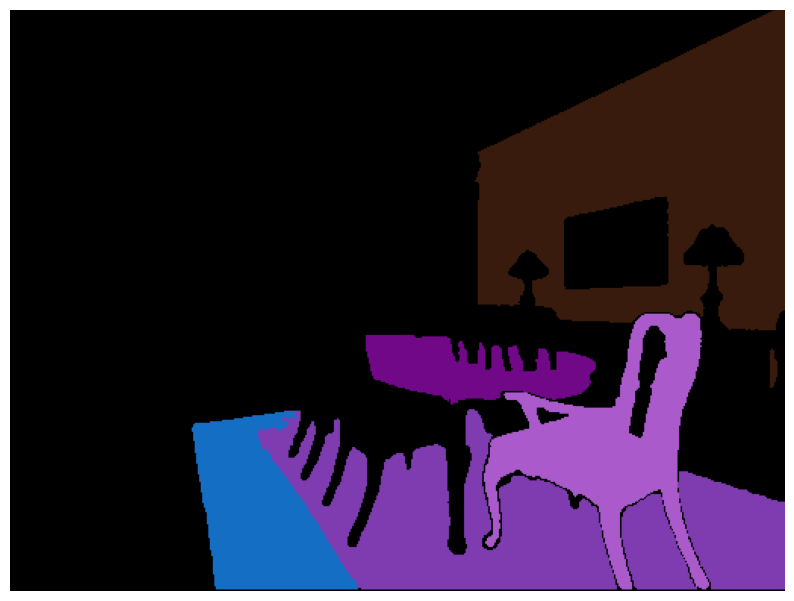

In [48]:
import numpy as np

def create_average_color_image(image, masks):
    """
    Create an image where each mask region is filled with the average color
    of the corresponding region in the input image.
    
    Args:
        image (numpy.ndarray): The original image (H, W, 3).
        masks (list[dict]): List of masks from SamAutomaticMaskGenerator.
    
    Returns:
        numpy.ndarray: The output image with average colors for each mask.
    """
    # Create an empty image to store the result
    output_image = np.zeros_like(image, dtype=np.float32)
    print(output_image.shape)
    for mask in masks:
        segmentation = mask['segmentation']  # Mask segmentation array
        bbox = mask['bbox']  # Bounding box [x, y, w, h]
        x, y, w, h = bbox
        cropped_image = image
        print("cropped image", cropped_image.shape)

        cropped_mask = segmentation
        print("cropped mask", cropped_mask.shape)
        mask_pixels = cropped_image[cropped_mask]
        print("mask_pixels", mask_pixels.shape)

        if mask_pixels.size > 0:
            average_color = mask_pixels.mean(axis=0)
            
            print("average_color", average_color)
            output_image[cropped_mask] = average_color

    # Clip values to valid range [0, 1] and convert to uint8
    return (output_image * 255).astype(np.uint8)
# Assuming `image` is the input image and `masks2` contains the masks
output_image = create_average_color_image(image, masks2)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()
